# Digits CNN Classifier in Azure ML 

## 1- Loading Necessary Libraries

In [45]:
import os
import azureml
from azureml.core import Experiment
from azureml.core import Environment
from azureml.core import Workspace, Run
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from keras.datasets import mnist
from matplotlib import pyplot

## 2- Loading the ML workspace

In [46]:
try:
    ws = Workspace.from_config()
    print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')
except:
    print('No workpsace found')

ml-workspace-1985	westeurope	containersrg	westeurope


## 3- Provision Compute Resources

In [47]:
cluster_name = "MLCompute"

try:
    cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D3_V2',
                                                           max_nodes=4)

    cluster = ComputeTarget.create(ws, cluster_name, compute_config)

    cluster.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


## 4- Load MNIST Dataset and Plot Sample Images from the training set

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


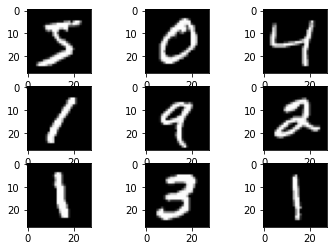

In [48]:
# load mnist dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))

# show the sample images from the training set
pyplot.show()

## 5- Preprocess Dataset

In the below function, we do the following preprocessing steps:
 - Casting the pixel values from unsigned integers to float type.
 - Normalize the values to be between 0 and 1 [0, 1]. 
 - Reshape the dataet to have a single channel as we deal with grey scale images. 
 - Finally we apply one-hot encoding on the target labels to convert each label from integer to one-hot encoded vector.

In [ ]:
def preprocess_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    #normalize pixel values 
    trainX = trainX.astype('float32')
    testX = testX.astype('float32')
    trainX = trainX / 255.0
    testX = testX / 255.0
    
    # reshape dataset to have a single channel (grey scale images)
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))

    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    return trainX, trainY, testX, testY

## 6- Prepare the training script file "digits_classifier_train.py"

In [75]:
%%writefile digits_classifier_train.py
import json
import os
from azureml.core import Run
from azureml.core.model import Model
import pickle
import keras
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense,Dropout, Flatten, MaxPooling2D, Conv2D, BatchNormalization

def preprocess_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    #normalize pixel values 
    trainX = trainX.astype('float32')
    testX = testX.astype('float32')
    trainX = trainX / 255.0
    testX = testX / 255.0
    
    # reshape dataset to have a single channel (grey scale images)
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))

    # one hot encode target labels
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    return trainX, trainY, testX, testY

x_train, y_train, x_test, y_test = preprocess_dataset()

parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=3)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--dropout', type=float)
parser.add_argument('--hidden', type=int, default=100)
parser.add_argument('--learning_rate', type=float, default=0.01)
parser.add_argument('--momentum', type=float, default=0.9)

args = parser.parse_args()

model = keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(args.hidden, activation='relu', kernel_initializer='he_uniform'))

if args.dropout is not None and args.dropout < 1:
    model.add(Dropout(args.dropout))
    
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

# compile model
opt = SGD(lr=args.learning_rate, momentum=args.momentum)

model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=args.batch_size,
          epochs=args.epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

os.makedirs('outputs',exist_ok=True)
model.save('outputs/digit_classifier_model.hdf5')

# Log metrics
run = Run.get_context()
run.log('Test Loss', score[0])
run.log('Accuracy', score[1])

Overwriting digits_classifier_train.py


## 7- Create a new Experiment, the Keras environment Object and ScriptRunConfig Object

In [73]:
from azureml.core import ScriptRunConfig
import argparse

experiment_name = 'Digits-Classifier'
experiment = Experiment(workspace=ws, name=experiment_name)

keras_env = Environment.from_conda_specification(name='keras-env', file_path='conda_dependencies.yaml')

script_folder = './'

args  = ['--epochs', 3,
         '--batch_size', 64,
         '--dropout', 0.3,
         '--hidden', 100,
         '--learning_rate', 0.01,
         '--momentum', 0.9]

src = ScriptRunConfig(source_directory=script_folder,
                      script='digits_classifier_train.py',
                      arguments=args,
                      compute_target=cluster,
                      environment=keras_env)

## 8- Run the experiment and Use Azure ML widgets to monitor the progress or the run

In [74]:
from azureml.widgets import RunDetails

run = experiment.submit(src)
run.wait_for_completion(show_output=True)

RunDetails(run).show()

RunId: Digits-Classifier_1616341856_340accc2
Web View: https://ml.azure.com/experiments/Digits-Classifier/runs/Digits-Classifier_1616341856_340accc2?wsid=/subscriptions/627b39d5-583d-4275-89b8-b43f00ec12c5/resourcegroups/containersrg/workspaces/ml-workspace-1985

Streaming azureml-logs/20_image_build_log.txt

2021/03/21 15:51:08 Downloading source code...
2021/03/21 15:51:10 Finished downloading source code
2021/03/21 15:51:10 Creating Docker network: acb_default_network, driver: 'bridge'
2021/03/21 15:51:11 Successfully set up Docker network: acb_default_network
2021/03/21 15:51:11 Setting up Docker configuration...
2021/03/21 15:51:11 Successfully set up Docker configuration
2021/03/21 15:51:11 Logging in to registry: omosaadacr.azurecr.io
2021/03/21 15:51:13 Successfully logged into omosaadacr.azurecr.io
2021/03/21 15:51:13 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/03/21 15:51:13 Scanning for dependencies...
2021/03

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…